In [4]:
# Author: Syed (codefather)
# Date: 2024-05-28

import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np
import os
import time
from os.path import join
from pycromanager import Core, start_headless, stop_headless

# creating required directories
os.makedirs('Autofocus', exist_ok=True)
os.makedirs('Stitches', exist_ok=True)
os.makedirs('Results', exist_ok=True)

# core should be global - to be fixed later
mm_app_path = "C:\\Program Files\\Micro-Manager-2.0"
config_file = "C:\\Program Files\\Micro-Manager-2.0\\IX81_LUDL_amscope_Laser532.cfg"
print("before")
# stop_headless()
# Start the headless process
# start_headless(mm_app_path, config_file, debug=False)
# time.sleep(1)
print("after")
core = Core()
print(core)
core.load_system_configuration(config_file)
print("loaded")

before
after
loaded


18 5.82506278444895


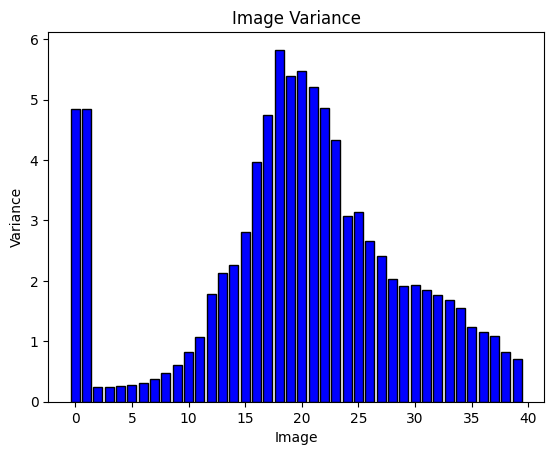

In [6]:
#%% Autofocus_WS_plane
def autofocus_plane(core:Core=None, path="", n_images=40, z_start=1350, step=1) -> None:
    # Record images along z axis
    # core.set_serial_port_command("COM13", "CURRENT=0", "\r\n")
    core.set_property("TransmittedLamp", "Label", "On")
    core.set_camera_device("AmScope")
    camera_name = core.get_camera_device()
    core.set_property(camera_name, "Binning", "1x1")
    core.set_property(camera_name, "PixelType", "GREY8")
    core.set_property(camera_name, "ExposureAuto", "0")
    core.set_exposure(15)
    
    width = core.get_image_width()
    height = core.get_image_height()
    byte_depth = core.get_bytes_per_pixel()
    zstage = core.get_focus_device()

    core.set_position(zstage, z_start)
    time.sleep(2)
    z_pos = core.get_position(zstage)
    offset = n_images // 2

    for z_val in range(z_start - offset, z_start + offset + 2, step):
        core.snap_image()
        img = core.get_image()
        img = np.max(img) - img
        if byte_depth == 1:
            ip = np.reshape(img, (height, width)).astype(np.uint8)
        elif byte_depth == 2:
            ip = np.reshape(img, (height, width)).astype(np.uint16)
        elif byte_depth == 4:
            ip = np.reshape(img, (height, width)).astype(np.uint32)
        else:
            raise ValueError(f'byte depth should be 1, 2 or 4. byte depth: {byte_depth}')
        
        img_index = z_val - z_start + offset

        if img_index == 0 or img_index == 1:
            pre_path = join(path, f"Autofocus/image_{img_index}.tif")
        else:
            pre_path = join(path, f"Autofocus/image_{img_index-2}.tif")
        
        tiff.imwrite(pre_path, ip) # photometric='minisblack'
        z_pos = z_val
        core.set_position(zstage, z_pos)
        # print(img_index, "z-position:", z_pos)

    max_var, max_var_index, variances = -1, -1, []
    for i in range(n_images):
        image = tiff.imread(join(path, f"Autofocus/image_{i}.tif"))
        mean, std = np.mean(image), np.std(image)
        norm_var = std * std / mean
        # print(i, mean, std, norm_var)
        variances.append(norm_var)
        if norm_var > max_var:
            max_var, max_var_index = norm_var, i
    
    z_pos = (z_start - offset) + (step * max_var_index)
    core.set_position(zstage, z_pos)
    # print("z-position:", z_pos, core.get_position(zstage))
    return max_var_index, max_var, variances

max_i, max_var, variances = autofocus_plane(core, n_images=40, z_start=1340)
print(max_i, max_var)

plt.bar(list(range(0, len(variances))), variances, color='blue', edgecolor='black')
plt.title('Image Variance')
plt.xlabel('Image')
plt.ylabel('Variance')
plt.show()

In [7]:
import cv2
from skimage.feature import peak_local_max
from skimage import io, img_as_ubyte
from skimage.transform import rescale


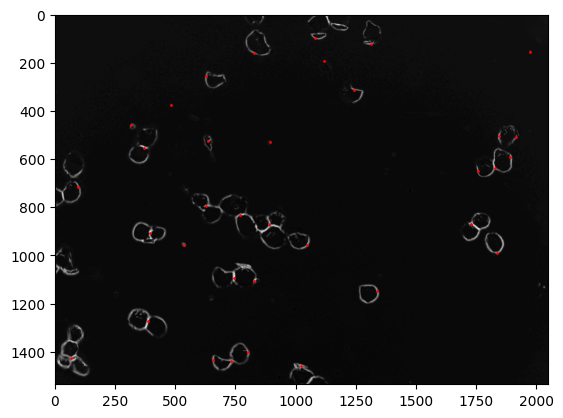

In [8]:
image_file = f"Autofocus/image_{max_i}.tif"
image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
coordinates = peak_local_max(image, min_distance=60, threshold_abs=15)
x_coords, y_coords = zip(*coordinates)
plt.imshow(image, cmap='gray')
plt.scatter(y_coords, x_coords, c='red', s=1)  

In [10]:
#%% image_grid -> cell_filter_isolation

def capture_image_grid(core:Core=None, path:str="", rows:int=4, cols:int=5) -> None:
    width = core.get_image_width()
    height = core.get_image_height()
    byte_depth = core.get_bytes_per_pixel()
    camera_name = core.get_camera_device()

    core.set_property(camera_name, "Binning", "1x1")
    core.set_property(camera_name, "PixelType", "GREY8")
    core.set_property(camera_name, "ExposureAuto", "0")
    core.set_exposure(25)

    xystage = core.get_xy_stage_device()
    pos_x = core.get_x_position(xystage)
    pos_y = core.get_y_position(xystage)

    x_origin = pos_x
    y_origin = pos_y

    # Grid settings
    n, m = cols, rows  
    inc_x = width  # step size in X direction
    inc_y = height  # step size in Y direction

    pos_x = pos_x - inc_x * (0.5 * n - 0.5)
    pos_y = pos_y - inc_y * (0.5 * m - 0.5)
    startx, starty = pos_x, pos_y
    cc = 0

    core.set_xy_position(pos_x, pos_y)
    time.sleep(1)

    for a in range(m):
        for b in range(n):
            pos_x = startx + inc_x * b
            pos_y = starty + inc_y * a
            print(pos_x, pos_y)

            core.set_xy_position(pos_x, pos_y)
            time.sleep(1)
            core.snap_image()
            img = core.get_image()
            img = np.max(img) - img

            if byte_depth == 1:
                ip = np.reshape(img, (height, width)).astype(np.uint8)
            elif byte_depth == 2:
                ip = np.reshape(img, (height, width)).astype(np.uint16)
            elif byte_depth == 4:
                ip = np.reshape(img, (height, width)).astype(np.uint32)
            else:
                raise ValueError(f'byte depth should be 1 or 2. byte depth: {byte_depth}')

            pre_path = os.path.join(path, f"Stitches/imageXY-{cc}.tif")
            tiff.imwrite(pre_path, ip, photometric='minisblack')
            cc += 1

    core.set_xy_position(x_origin, y_origin)

capture_image_grid(core)
print("done")

3428.3 -692.3
5476.3 -692.3
7524.3 -692.3
9572.3 -692.3
11620.3 -692.3
3428.3 843.7
5476.3 843.7
7524.3 843.7
9572.3 843.7
11620.3 843.7
3428.3 2379.7
5476.3 2379.7
7524.3 2379.7
9572.3 2379.7
11620.3 2379.7
3428.3 3915.7
5476.3 3915.7
7524.3 3915.7
9572.3 3915.7
11620.3 3915.7
done


image saved
inverted
(6144, 10240)


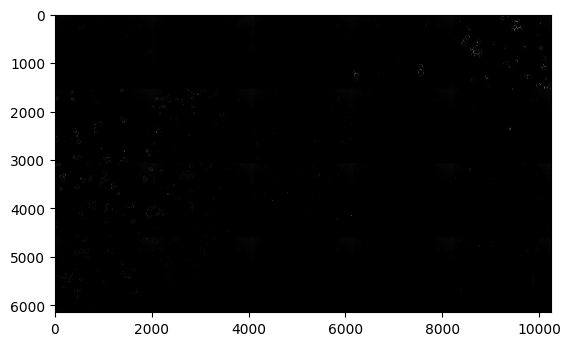

rescaled
peak algo finished
[[ 175  555]
 [ 165  825]
 [ 277 1529]
 [ 930 1645]
 [1085  163]
 [ 355 1399]]


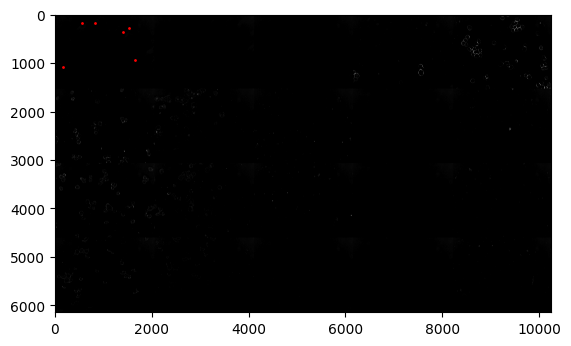

done


In [52]:
import cv2
from skimage.feature import peak_local_max
from skimage import io, img_as_ubyte
from skimage.transform import rescale


def stitch_images(core:Core=None, path:str="", rows:int=4, cols:int=5) -> None:
    n, m = cols, rows 
    input_dir = os.path.join(path, "Stitches")
    image_files = [os.path.join(input_dir, f"imageXY-{i}.tif") for i in range(0, n * m)]
    stitched_image_rows = []

    # stitching all images by row
    for row in range(m):
        stitched_row = None
        for col in range(n):
            image_file = image_files[row*n + col]
            image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
            
            if stitched_row is None:
                stitched_row = image
            else:
                stitched_row = np.hstack((stitched_row, image))

        stitched_image_rows.append(stitched_row)

    stitched_image = np.vstack(stitched_image_rows)
    stitched_image_path = os.path.join(input_dir, "stitchedImage.tif")
    cv2.imwrite(stitched_image_path, stitched_image)

    # stitched_image = img_as_ubyte(stitched_image) # converting to 8-bit unsigned
    print("image saved")
    # plt.imshow(stitched_image, cmap='gray')
    # plt.show()
    # stitched_image = np.max(stitched_image) - stitched_image
    print("inverted")
    # stitched_image = stitched_image[:2000, 8000:]
    print(stitched_image.shape)
    # stitched_image = rescale(stitched_image, 1, anti_aliasing=False)
    plt.imshow(stitched_image, cmap='gray')
    plt.show()
    print("rescaled")
    # finding maxima
    coordinates = peak_local_max(image, min_distance=60, threshold_abs=15)
    print("peak algo finished")

    # result_file = os.path.join(input_dir, "cell_positions.txt")
    # with open(result_file, 'w') as f:
    #     for coord in coordinates:
    #         f.write(f"{coord[1]},{coord[0]}\n")
    return stitched_image, coordinates
    
image, cells_ = stitch_images()

print(cells_)
x_coords, y_coords = zip(*cells_)
plt.imshow(image, cmap='gray')
plt.scatter(y_coords, x_coords, c='red', s=1) 
plt.show()

print("done")

In [ ]:
def cell_filter_isolation(core:Core=None, path:str="", cell_xy:list=[], n_filtered:int=0) -> None:
    # for testing purpose only
    # cell_xy = np.array([
    #     [1041, 2009], [86, 1984], [1412, 1982], [1003, 1979], [2030, 1971],
    #     [1273, 1960], [1477, 1954], [2356, 1918], [2070, 1949], [2080, 1947],
    #     [2028, 1937], [1522, 1937], [2305, 1929], [946, 1912], [213, 1894],
    #     [505, 1853], [2182, 1830], [582, 1821], [530, 1811], [2192, 1802],
    #     [538, 1790], [170, 1787], [2090, 1784], [2220, 1780], [214, 1775]
    # ])
    # n_filtered = 19

    n_cells = len(cell_xy)
    if n_cells < n_filtered:
        n_filtered = n_cells

    min_distance = np.full(n_cells, np.inf)
    cell_pos = cell_xy.copy()

    # finding nearest cell to it to each cell
    for i in range(n_cells):
        for j in range(n_cells):
            if i != j:
                distance = np.linalg.norm(cell_pos[i] - cell_pos[j])
                if distance < min_distance[i]:
                    min_distance[i] = distance

    # filtering most isolated cells
    min_distance_sorted = np.sort(min_distance)
    threshold = min_distance_sorted[-n_filtered]

    cell_filtered = []
    for i in range(n_cells):
        if min_distance[i] >= threshold and len(cell_filtered) < n_filtered:
            cell_filtered.append(cell_pos[i])

    cell_filtered = np.array(cell_filtered)

    return n_cells, cell_filtered


n_cells, cell_filtered = cell_filter_isolation(cell_xy=cells, n_filtered=10)

In [ ]:

def cell_probe_order_nn(core:Core=None, path:str="", cell_xy:list=[]) -> None:
    # for testing purpose only
    # cell_xy = np.array([
    #     [1041, 2009], [86, 1984], [1412, 1982], [1003, 1979], [2030, 1971],
    #     [1273, 1960], [1477, 1954], [2356, 1918], [2070, 1949], [2080, 1947],
    #     [2028, 1937], [1522, 1937], [2305, 1929], [946, 1912], [213, 1894],
    #     [505, 1853], [2182, 1830], [582, 1821], [530, 1811], [2192, 1802],
    #     [538, 1790], [170, 1787], [2090, 1784], [2220, 1780], [214, 1775]
    # ])

    n_cells = len(cell_xy)
    isVisited = np.zeros(n_cells, dtype=bool)
    nn_cells = np.zeros((n_cells, 2), dtype=int)

    test_cell_x, test_cell_y = cell_xy[0]
    nn_cells[0] = cell_xy[0]
    isVisited[0] = True

    for i in range(1, n_cells):
        minDistance = float('inf')
        minIndex = -1
        for j in range(n_cells):
            if not isVisited[j]:
                distance = np.sqrt((test_cell_x - cell_xy[j, 0])**2 + (test_cell_y - cell_xy[j, 1])**2)
                if distance < minDistance:
                    minDistance = distance
                    minIndex = j
        nn_cells[i] = cell_xy[minIndex] 
        isVisited[minIndex] = True
        test_cell_x, test_cell_y = cell_xy[minIndex]

    output_file = os.path.join(path, "Results", "cell_Positions.txt")
    with open(output_file, 'w') as f:
        for k in range(n_cells):
            f.write(f"{nn_cells[k, 0]},{nn_cells[k, 1]}\n")

    return nn_cells

cell_xy, relative_cell_xy  = cell_probe_order_nn(cell_xy=cells)